Football Injury Datasets

https://nflreadr.nflverse.com/reference/load_injuries.html

https://nflreadr.nflverse.com/reference/load_rosters.html

https://nflreadr.nflverse.com/reference/load_players.html

https://nflreadr.nflverse.com/reference/load_combine.html

https://nflreadr.nflverse.com/articles/dictionary_injuries.html

https://nflreadr.nflverse.com/articles/dictionary_rosters.html

https://nflreadr.nflverse.com/articles/dictionary_combine.html

In [2]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
years = list(range(2009, 2025))

combine_df = nfl.clean_nfl_data(nfl.import_combine_data(years=years))
rosters_df = nfl.clean_nfl_data(nfl.import_seasonal_rosters(years=years))
injuries_df = nfl.clean_nfl_data(nfl.import_injuries(years=years))

combine_df = combine_df.drop(columns=['season'])

In [4]:
valid_injury_types = [
    "knee", "ankle", "hamstring", "shoulder", "foot", "concussion",
    "groin", "back", "calf", "hip", "neck", "toe", "quadricep", "elbow",
    "hand", "rib", "wrist", "thumb", "abdomen", "head", "finger", "achilles",
    "shin", "pectoral", "forearm", "heel", "biceps", "fibula"
]

valid_pos_types = ['WR', 'LB', 'C', 'RB', 'CB', 'DT', 'TE', 'S', 'T', 'G', 'DE', 'P', 'LS', 'QB']

def extract_valid_injury(report):
    if pd.isna(report):
        return None
    report_lower = report.lower()
    for i, injury in enumerate(valid_injury_types):
        if injury in report_lower:
            return injury
    return None

def extract_injury_index(report):
    if pd.isna(report):
        return None
    return valid_injury_types.index(report)

def extract_pos_index(report):
    if pd.isna(report):
        return None
    return valid_pos_types.index(report)

roster_injury_df = pd.merge(
    rosters_df,
    injuries_df,
    left_on=['player_name', 'season', 'team', 'position'],
    right_on=['full_name', 'season', 'team', 'position'],
    how='left'
)

merged_df = pd.merge(
    roster_injury_df,
    combine_df,
    left_on=['player_name'],
    right_on=['player_name'],
    how='left'
)

merged_df = merged_df[['season', 'player_name', 'position', 'height', 'weight', 'age', 'report_primary_injury', 'forty', 'bench', 'vertical']]
merged_df["injury"] = merged_df["report_primary_injury"].apply(extract_valid_injury)
merged_df = merged_df.dropna()
merged_df = merged_df.drop(columns=['report_primary_injury'])

merged_df["injury_index"] = merged_df["injury"].apply(extract_injury_index).astype(int)
merged_df["position_index"] = merged_df["position"].apply(extract_pos_index).astype(int)

merged_df = merged_df.sort_values(by=['player_name', 'season'])
merged_df

for i, injury in enumerate(valid_injury_types):
    merged_df[f"prev_{injury}"] = 0
    merged_df[f"prev_{injury}"] = merged_df.groupby(['player_name']).apply(
        lambda group: (group['injury'] == injury).cumsum().shift(fill_value=0)
    ).reset_index(level=0, drop=True)

merged_df.to_csv("data.csv", index=False)
merged_df["injury"].value_counts()

knee          1698
ankle         1500
hamstring     1147
shoulder       749
concussion     509
foot           455
groin          373
back           295
calf           280
hip            270
toe            233
rib            170
quadricep      141
elbow          117
neck           107
hand            96
abdomen         78
wrist           70
thumb           67
finger          61
achilles        51
pectoral        34
heel            29
head            29
biceps          19
shin            19
forearm         15
fibula          12
Name: injury, dtype: int64

In [5]:
merged_df['position'].unique()

array(['WR', 'LB', 'C', 'RB', 'CB', 'DT', 'TE', 'S', 'T', 'G', 'DE', 'P',
       'LS', 'QB'], dtype=object)

In [6]:
injury_reports.boxplot(column='weight', by='report_primary_injury', figsize=(12, 6))
plt.title('Weight Distribution by Injury Type')
plt.suptitle('')  # Removes the default subtitle
plt.xlabel('Injury Type')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.show()

NameError: name 'injury_reports' is not defined

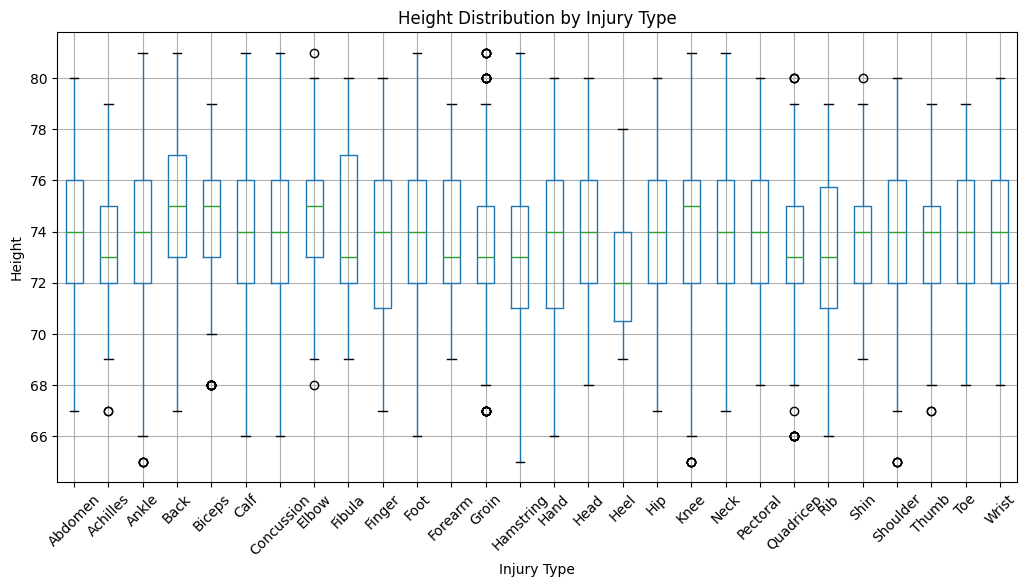

In [47]:
injury_reports.boxplot(column='height', by='report_primary_injury', figsize=(12, 6))
plt.title('Height Distribution by Injury Type')
plt.suptitle('')  # Removes the default subtitle
plt.xlabel('Injury Type')
plt.ylabel('Height')
plt.xticks(rotation=45)
plt.show()

In [48]:
import scipy.stats as stats

injury_types = injury_reports['report_primary_injury'].unique()

groups_age = [injury_reports[injury_reports['report_primary_injury'] == injury]['age'] for injury in injury_types]

f_stat_age, p_value_age = stats.f_oneway(*groups_age)
print("ANOVA results for age: F-statistic =", f_stat_age, ", p-value =", p_value_age)

ANOVA results for age: F-statistic = 25.562877601860148 , p-value = 3.423824477163067e-127


In [49]:
injury_reports.columns

Index(['season', 'age', 'height', 'weight', 'report_primary_injury'], dtype='object')